# Mercari Price Suggestion Challenge

## Overview

Mercari is a community-powered shopping app from Japan allowing anyone to buy and sell anything from anywhere.

Predicting the price of a product is a tough challenge since very similar products having minute differences such as different brand names, additional specifications, quality of the product, the demand of the product, etc. can have very different prices. 

Price prediction gets even more difficult when there is a huge range of products, which is common with most online shopping platforms. While it might be simpler to predict the price of a particular category of products using some simple criteria, it’s highly challenging to predict the price of almost anything that is listed on online platforms. We may have multiple listings of the same product by a large number of sellers priced differently.



## Data collection

The data can be downloaded from <a href="https://www.kaggle.com/c/mercari-price-suggestion-challenge/data">Kaggle</a> competion page.<br>

We have been provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition

## ML Problem

Using the given data, we have to come up with a model that predicts the price of a product listed on Mercari as accurately as possible.

This is a standard regression problem.

## Performance Metric

The performance of the model is measured by Root Mean Squared Logarithmic Error(RMSLE). The lesser the RMSLE, the better is our prediction model. <br>

The RMSLE is calculated as
\begin{align*}
\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
\end{align*}<br>

- ϵ is the RMSLE value (score)
- n is the total number of observations in the (public/private) data set,
- pi is your prediction of price, and
- ai is the actual sale price for i
- log(x) is the natural logarithm of x

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import datetime
import gc
from tqdm import tqdm

import pandas as pd
import numpy as np
from numpy import median

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.manifold import TSNE
from sklearn import preprocessing

from collections import Counter

import string
import re
from nltk.corpus import stopwords

import scipy
from scipy import hstack


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
#from sklearn.feature_selection.univariate_selection import SelectKBest, f_regression


import tracemalloc
import time

In [2]:
tracemalloc.start()

start_time = time.time()
snapshot1 = tracemalloc.take_snapshot()

## 0. Loading data

In [3]:
# https://www.kaggle.com/peterhurford/lgb-and-fm-18th-place-0-40604
def split_cat(text):
    try:
        return text.split("/")
    except:
        return ("No Label", "No Label", "No Label")

In [4]:
df_train = pd.read_csv('train.tsv', sep='\t', 
                      dtype={'item_condition_id': 'category', 'shipping': 'category'}, 
                      converters={'category_name': split_cat})


df_test = pd.read_csv('test.tsv', sep='\t', 
                     dtype={'item_condition_id': 'category', 'shipping': 'category'}, 
                     converters={'category_name': split_cat})

In [5]:
print('Shape of train data: ', df_train.shape)

print('Shape of test data: ', df_test.shape)

Shape of train data:  (1482535, 8)
Shape of test data:  (693359, 7)


In [6]:
df_train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,"[Men, Tops, T-shirts]",NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,"[Electronics, Computers & Tablets, Components ...",Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,"[Women, Tops & Blouses, Blouse]",Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,"[Home, Home Décor, Home Décor Accents]",NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,"[Women, Jewelry, Necklaces]",NaN,44.0,0,Complete with certificate of authenticity


In [7]:
df_test.head(5)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,"[Women, Jewelry, Rings]",NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,"[Other, Office supplies, Shipping Supplies]",NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,"[Vintage & Collectibles, Bags and Purses, Hand...",Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,"[Women, Sweaters, Cardigan]",NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,"[Other, Books, Religion & Spirituality]",NaN,1,Rediscovering life after the loss of a loved o...


## 1. Data Overview

### Missing values check

In [8]:
df_train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [9]:
df_test.isnull().any()

test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name            True
shipping             False
item_description     False
dtype: bool

Observation:
-------------------

* We found the columns brand_name and item_description  have null values.

* Null values in category_name have been replaced by empty lists because of the converter we have used while loading the data.

* We will replace null values, and empty lists with *' missing'*.

In [10]:
# Split category_name by '/' into subcategories and replace nulls with 'missing'

df_train['gencat_name'] = df_train['category_name'].str.get(0).replace('', 'missing').astype('category')
df_train['subcat1_name'] = df_train['category_name'].str.get(1).fillna('missing').astype('category')
df_train['subcat2_name'] = df_train['category_name'].str.get(2).fillna('missing').astype('category')

df_train.drop('category_name', axis=1, inplace=True)

In [11]:
# Split category_name by '/' into subcategories and replace nulls with 'missing'

df_test['gencat_name'] = df_test['category_name'].str.get(0).replace('', 'missing').astype('category')
df_test['subcat1_name'] = df_test['category_name'].str.get(1).fillna('missing').astype('category')
df_test['subcat2_name'] = df_test['category_name'].str.get(2).fillna('missing').astype('category')

df_test.drop('category_name', axis=1, inplace=True)

In [12]:
df_train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,gencat_name,subcat1_name,subcat2_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [13]:
df_train['item_description'].fillna('missing', inplace=True)

df_train['brand_name'] = df_train['brand_name'].fillna('missing').astype('category')

In [14]:
df_test['item_description'].fillna('missing', inplace=True)

df_test['brand_name'] = df_test['brand_name'].fillna('missing').astype('category')

In [15]:
df_train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,gencat_name,subcat1_name,subcat2_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


### Check for duplicate rows, NAs

In [16]:
df_train[df_train.duplicated()]

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,gencat_name,subcat1_name,subcat2_name


No duplicate rows in train data

In [17]:
df_train.isnull().any()

train_id             False
name                 False
item_condition_id    False
brand_name           False
price                False
shipping             False
item_description     False
gencat_name          False
subcat1_name         False
subcat2_name         False
dtype: bool

### Check for rows with invalid price

In [18]:
print('Removed {} rows' .format(len(df_train[df_train.price<=0])))

df_train = df_train[df_train.price > 0].reset_index(drop=True)

Removed 874 rows


### Column-wise overview of data

#### name

In [19]:
df_train['name'].describe()

count     1481661
unique    1224596
top        Bundle
freq         2232
Name: name, dtype: object

#### item_condition_id

In [20]:
df_train['item_condition_id'].describe()

count     1481661
unique          5
top             1
freq       640246
Name: item_condition_id, dtype: object

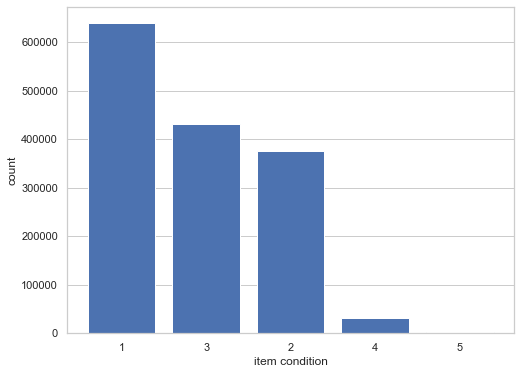

In [21]:
condition_count = Counter(list(df_train['item_condition_id']))
x, y = zip(*condition_count.most_common())
plt.figure(figsize=[8,6])
plt.bar(x, y, )

plt.xlabel('item condition')
plt.ylabel('count')
plt.grid(False, axis='x')
plt.show()

Observation:
------------------

* Condition 1 has the highest majority, followed by Condition 3 and Condition 2

#### brand_name

In [22]:
df_train['brand_name'].describe()  

count     1481661
unique       4808
top       missing
freq       632336
Name: brand_name, dtype: object

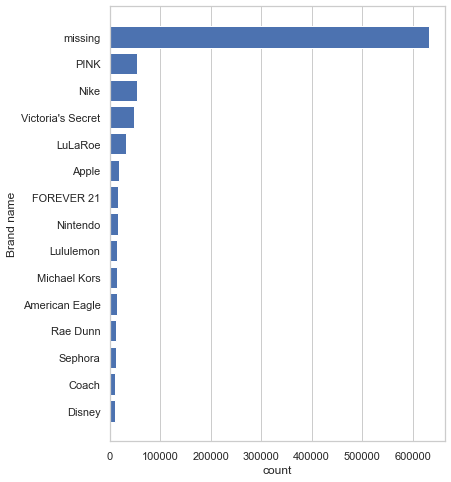

In [23]:
brand_count = Counter(list(df_train['brand_name'].values))
x, y = zip(*brand_count.most_common(15))

plt.figure(figsize=[6,8])
plt.barh(x, y)
plt.gca().invert_yaxis()
plt.ylabel('Brand name')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

In [24]:
brand_missing = df_train[df_train['brand_name']=='missing'].shape[0]

print('Brand name is missing for {} datapoints, i.e. {:.2f} % of train data.' 
      .format(brand_missing, 100.0*brand_missing/df_train.shape[0]))

Brand name is missing for 632336 datapoints, i.e. 42.68 % of train data.


#### Observation

* Missing name has the highest majority,it almost covers 43% of data.

#### gencat_name

In [25]:
df_train['gencat_name'].describe()

count     1481661
unique         11
top         Women
freq       663990
Name: gencat_name, dtype: object

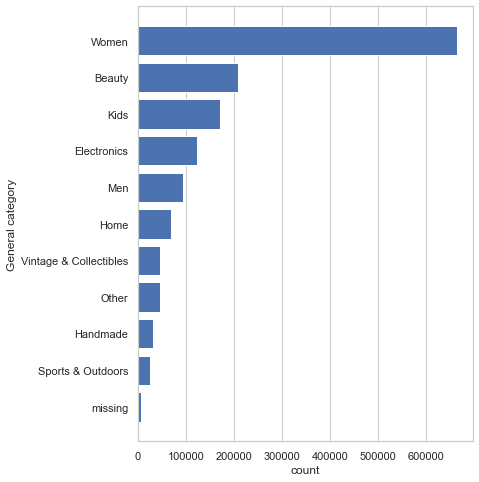

In [26]:
gencat_count = Counter(list(df_train['gencat_name'].values))
x, y = zip(*gencat_count.most_common(15))
plt.figure(figsize=[6,8])
plt.barh(x, y)

plt.gca().invert_yaxis()
plt.ylabel('General category')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

In [27]:
gencat_missing = df_train[df_train['gencat_name']=='missing'].shape[0]

print('category name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(gencat_missing, 100.0*gencat_missing/df_train.shape[0]))

category name is missing for 6314 datapoints, i.e. 0.43 % of train data.


#### Observation

* Woman has the highest majority

* Almost 0.43% of data is missing.

#### subcat1_name

In [28]:
df_train['subcat1_name'].describe()

count              1481661
unique                 114
top       Athletic Apparel
freq                134321
Name: subcat1_name, dtype: object

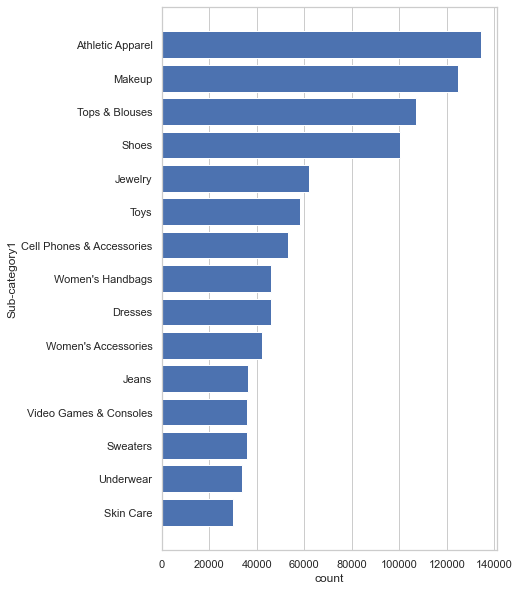

In [29]:
subcat1_count = Counter(list(df_train['subcat1_name'].values))
x, y = zip(*subcat1_count.most_common(15))
plt.figure(figsize=[6,10])
plt.barh(x, y)

plt.gca().invert_yaxis()
plt.ylabel('Sub-category1')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

In [30]:
subcat1_missing = df_train[df_train['subcat1_name']=='missing'].shape[0]

print('subcategory1 name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(subcat1_missing, 100.0*subcat1_missing/df_train.shape[0]))

subcategory1 name is missing for 6314 datapoints, i.e. 0.43 % of train data.


#### Observation:
 
* Athletic Apperal has the highest majority

#### subcat2_name

In [31]:
df_train['subcat2_name'].describe()

count                     1481661
unique                        871
top       Pants, Tights, Leggings
freq                        60152
Name: subcat2_name, dtype: object

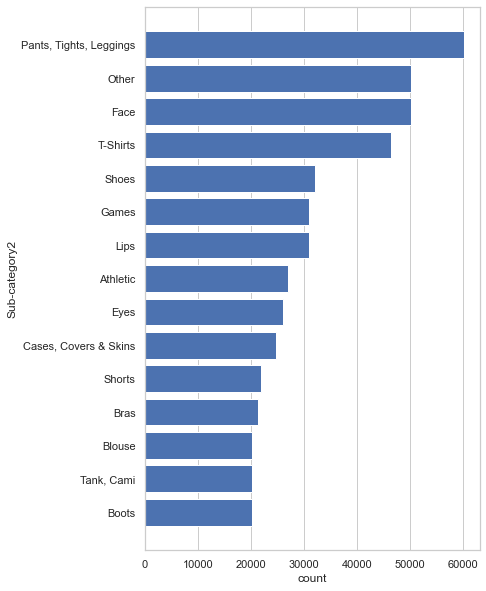

In [32]:
subcat2_count = Counter(list(df_train['subcat2_name'].values))
x, y = zip(*subcat2_count.most_common(15))
plt.figure(figsize=[6,10])
plt.barh(x, y)

plt.gca().invert_yaxis()
plt.ylabel('Sub-category2')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

In [33]:
subcat2_missing = df_train[df_train['subcat2_name']=='missing'].shape[0]

print('subcategory2 name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(subcat2_missing, 100.0*subcat2_missing/df_train.shape[0]))

subcategory2 name is missing for 6314 datapoints, i.e. 0.43 % of train data.


#### Observation:
 
* Pants,Tights,Leggings has the highest majority

#### item_description

In [34]:
desc_missing = df_train[df_train['item_description']=='missing'].shape[0]

print('item description is missing for {} datapoints, i.e. {:.5f} % of train data.' .format(desc_missing, 100.0*desc_missing/df_train.shape[0]))

item description is missing for 4 datapoints, i.e. 0.00027 % of train data.


In [35]:
df_train[df_train['item_description']=='missing']

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,gencat_name,subcat1_name,subcat2_name
511264,511535,Shoes for Michelle,4,missing,9.0,0,missing,Kids,Girls 0-24 Mos,Shoes
860756,861230,Lipgloss,4,missing,49.0,0,missing,Beauty,Makeup,Lips
1224217,1224924,Disney Minnie Head band,3,Disney,9.0,0,missing,Women,Women's Accessories,Hair Accessories
1263521,1264242,For Bianca,3,missing,10.0,1,missing,Women,Women's Accessories,Scarves & Wraps


#### price

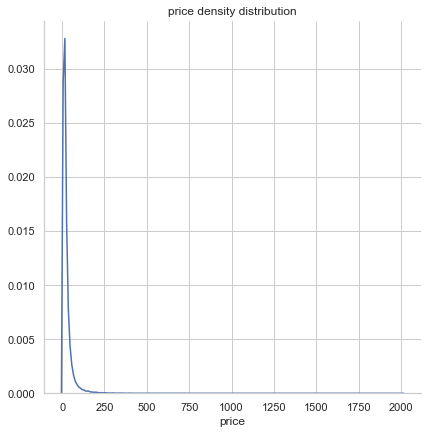

In [36]:
sns.FacetGrid(df_train,size=6) \
    .map(sns.kdeplot,"price") \
    .add_legend();
plt.title('price density distribution')
plt.show();

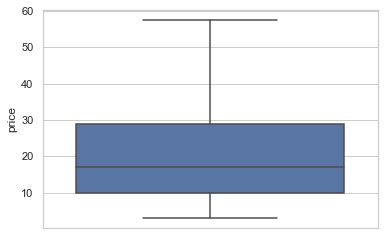

In [37]:
sns.boxplot(y='price', data=df_train, showfliers=False)
plt.show()

In [38]:
for i in range(0, 100, 10):
    var =df_train["price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])


print("**" * 25)

for i in range(90, 100, 1):
    var =df_train["price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 3.0
10 percentile value is 7.0
20 percentile value is 10.0
30 percentile value is 12.0
40 percentile value is 14.0
50 percentile value is 17.0
60 percentile value is 20.0
70 percentile value is 26.0
80 percentile value is 34.0
90 percentile value is 51.0
100 percentile value is  2009.0
**************************************************
90 percentile value is 51.0
91 percentile value is 55.0
92 percentile value is 58.0
93 percentile value is 62.0
94 percentile value is 67.0
95 percentile value is 75.0
96 percentile value is 85.0
97 percentile value is 99.0
98 percentile value is 122.0
99 percentile value is 170.0
100 percentile value is  2009.0


 #### Observation
 
 * 97% of data points have prices less than 100 value
 
 * Very few data points have prices over 170

## 2. Pre-processing

In [39]:
def preprocess_name(text_col):
    
    preprocessed_names = []
    
    for sentence in tqdm(text_col.values):
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        preprocessed_names.append(sent.lower().strip())
    
    return preprocessed_names

stopwords = stopwords.words('english')

def preprocess_description(text_col):
    
    preprocessed_descs = []
    
    for sentence in tqdm(text_col.values):
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed_descs.append(sent.lower().strip())
        
    return preprocessed_descs

In [40]:
df_train['preprocessed_name'] = preprocess_name(df_train['name'])

df_test['preprocessed_name'] = preprocess_name(df_test['name'])


df_train['preprocessed_description'] = preprocess_description(df_train['item_description'])

df_test['preprocessed_description'] = preprocess_description(df_test['item_description'])


100%|████████████████████████████████████████████████████████████████████████| 693359/693359 [01:37<00:00, 7103.13it/s]


In [41]:
def clean_category(categorical_values):
    '''takes categorical column values as arguments and returns list of cleaned categories'''
    
    catogories = list(categorical_values)

    categorical_values_list = []
    for i in tqdm(catogories):
        i = re.sub('[^A-Za-z0-9]+', ' ', i)
        i = i.replace(' ','')
        i = i.replace('&','_')
        categorical_values_list.append(i.strip())
    
    return categorical_values_list 

In [42]:
df_train['gencat_name'] = clean_category(df_train['gencat_name'].values)
df_test['gencat_name'] = clean_category(df_test['gencat_name'].values)

df_train['subcat1_name'] = clean_category(df_train['subcat1_name'].values)
df_test['subcat1_name'] = clean_category(df_test['subcat1_name'].values)

df_train['subcat2_name'] = clean_category(df_train['subcat2_name'].values)
df_test['subcat2_name'] = clean_category(df_test['subcat2_name'].values)

100%|██████████████████████████████████████████████████████████████████████| 693359/693359 [00:04<00:00, 140672.82it/s]


## 3. Basic Exploratory Data Analysis

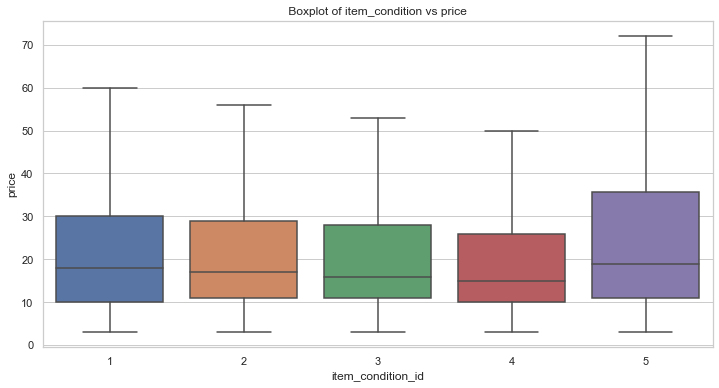

In [46]:
sns.set(style='whitegrid')
plt.figure(figsize=(12,6))
sns.boxplot(x='item_condition_id', y='price', data=df_train, showfliers=False)
plt.title(' Boxplot of item_condition vs price ')
plt.show()

Observation
------------------

* Median Price decreases as we go from condition 1 to 4. 

* Items in condition 5 seem to be having a higher median price.

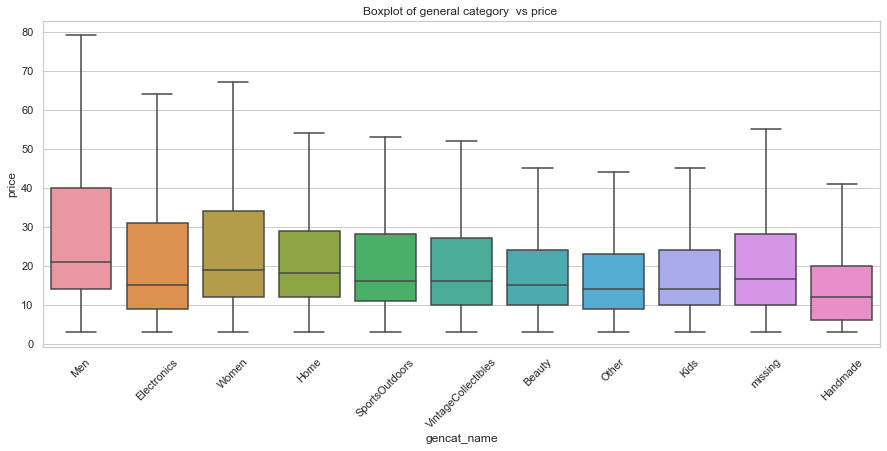

In [47]:
plt.figure(figsize=(15,6))
sns.boxplot(y='price', x='gencat_name', data=df_train, showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of general category  vs price ')
plt.show()

Observation
------------------

* Median Prices are high for Men, Women and Missing

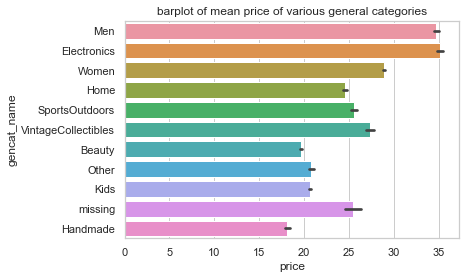

In [49]:
sns.barplot(y='gencat_name', x='price', data=df_train)
plt.title('barplot of mean price of various general categories')
plt.show()

Observation
------------------

* Mean Prices are high for Men and Electronics

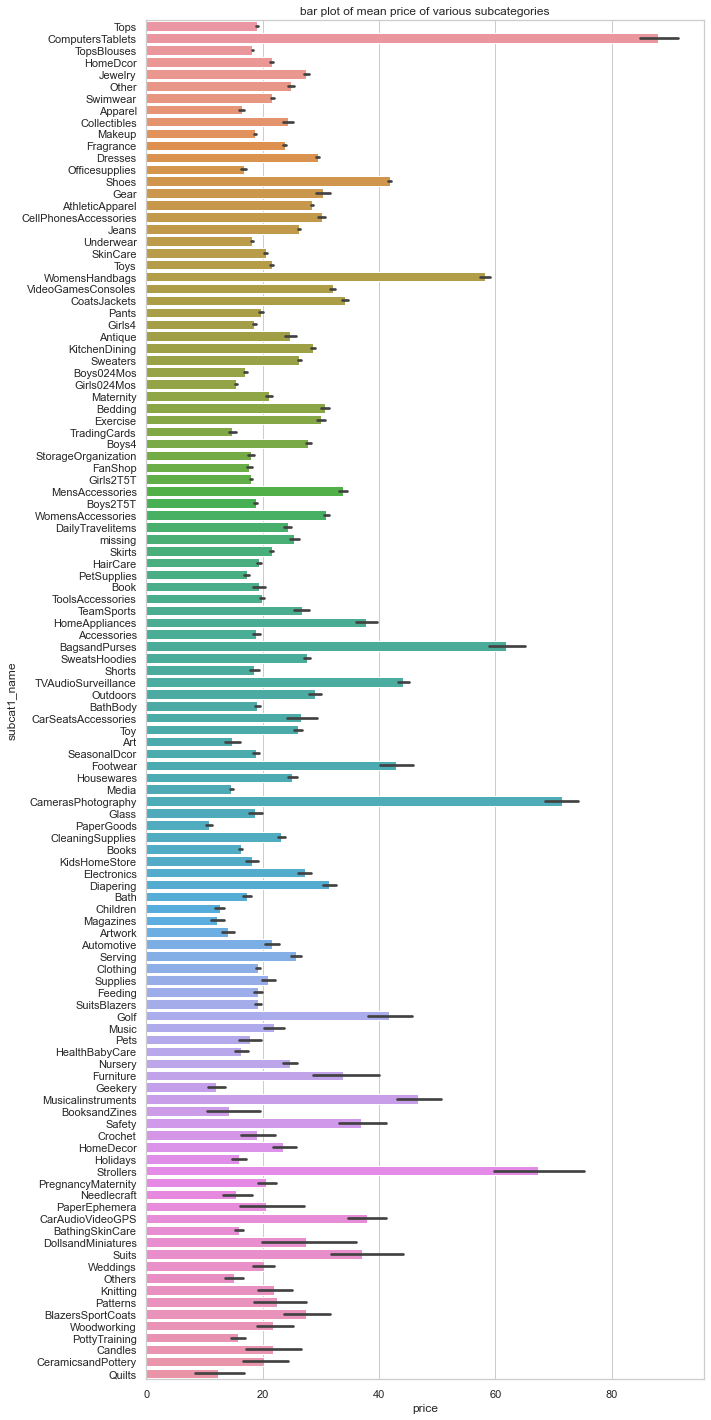

In [51]:
plt.figure(figsize=(10,25))
sns.barplot(y='subcat1_name', x='price', data=df_train)
plt.title('bar plot of mean price of various subcategories')
plt.show()

Observation
------------------

* Mean prices are high for a few subcategories like computer table, woman handbag etc.

In [53]:
""" extract the first name  from the name features """

def get_name_first(name):
    
    name =  re.sub('[^A-Za-z0-9]+', ' ', name) .split()
    if len(name):
            return name[0].lower()
    return ''
        
        
df_train['name_first'] = df_train['name'].apply(get_name_first)
df_test['name_first'] = df_test['name'].apply(get_name_first)

In [54]:
'''
    Return the feature column of the test data by mapping from the values already calculated for the same column in train data
    
'''

def transform_test(base_col, feat_col):
    
    #Create dictionary of feature values from train data
    di = pd.Series(df_train[feat_col].values, index=df_train[base_col].values).to_dict()
    
    #Map test data using dictionary and fill NAs with 0
    
    if base_col == 'item_condition_id':
        #No chance of NAs
        return df_test[base_col].map(di).astype(float)
        
    return df_test[base_col].map(di).fillna(0)

In [55]:
df_train['name_first_count'] = df_train.groupby('name_first')['name_first'].transform('count')
df_test['name_first_count'] = transform_test('name_first', 'name_first_count')

df_train['gencat_name_count'] = df_train.groupby('gencat_name')['gencat_name'].transform('count')
df_test['gencat_name_count'] = transform_test('gencat_name', 'gencat_name_count')

df_train['subcat1_name_count'] = df_train.groupby('subcat1_name')['subcat1_name'].transform('count')
df_test['subcat1_name_count'] = transform_test('subcat1_name', 'subcat1_name_count')

df_train['subcat2_name_count'] = df_train.groupby('subcat2_name')['subcat2_name'].transform('count')
df_test['subcat2_name_count'] = transform_test('subcat2_name', 'subcat2_name_count')

df_train['brand_name_count'] = df_train.groupby('brand_name')['brand_name'].transform('count')
df_test['brand_name_count'] = transform_test('brand_name', 'brand_name_count')

In [56]:
"""
NameLower: lowercase letters in name
DescriptionLower: lowercase letters in description
NameUpper: uppercase letters in name
DescriptionUpper: uppercase letters in description
name_len: char length of name
des_len: char length of desc
name_desc_len_ratio: name_len / des_len
mean_des: 10 * desc_word_count / des_len
mean_name: 10 * name_word_count / name_len
desc_letters_per_word: des_len / desc_word_count
name_letters_per_word: name_len / name_word_count
NameLowerRatio: NameLower / name_len
DescriptionLowerRatio: DescriptionLower / des_len
NameUpperRatio: NameUpper / name_len
DescriptionUpperRatio : DescriptionUpper / des_len

"""

df_train['NameLower'] = df_train.name.str.count('[a-z]')
df_train['DescriptionLower'] = df_train.item_description.str.count('[a-z]')
df_train['NameUpper'] = df_train.name.str.count('[A-Z]')
df_train['DescriptionUpper'] = df_train.item_description.str.count('[A-Z]')
df_train['name_len'] = df_train['name'].apply(lambda x: len(x))
df_train['des_len'] = df_train['item_description'].apply(lambda x: len(x))
df_train['name_desc_len_ratio'] = df_train['name_len']/df_train['des_len']
df_train['desc_word_count'] = df_train['item_description'].apply(lambda x: len(x.split()))
df_train['mean_des'] = df_train['item_description'].apply(lambda x: 0 if len(x) == 0 else float(len(x.split())) / len(x)) * 10
df_train['name_word_count'] = df_train['name'].apply(lambda x: len(x.split()))
df_train['mean_name'] = df_train['name'].apply(lambda x: 0 if len(x) == 0 else float(len(x.split())) / len(x))  * 10
df_train['desc_letters_per_word'] = df_train['des_len'] / df_train['desc_word_count']
df_train['name_letters_per_word'] = df_train['name_len'] / df_train['name_word_count']
df_train['NameLowerRatio'] = df_train['NameLower'] / df_train['name_len']
df_train['DescriptionLowerRatio'] = df_train['DescriptionLower'] / df_train['des_len']
df_train['NameUpperRatio'] = df_train['NameUpper'] / df_train['name_len']
df_train['DescriptionUpperRatio'] = df_train['DescriptionUpper'] / df_train['des_len']

In [57]:
"""
NameLower: lowercase letters in name
DescriptionLower: lowercase letters in description
NameUpper: uppercase letters in name
DescriptionUpper: uppercase letters in description
name_len: char length of name
des_len: char length of desc
name_desc_len_ratio: name_len / des_len
mean_des: 10 * desc_word_count / des_len
mean_name: 10 * name_word_count / name_len
desc_letters_per_word: des_len / desc_word_count
name_letters_per_word: name_len / name_word_count
NameLowerRatio: NameLower / name_len
DescriptionLowerRatio: DescriptionLower / des_len
NameUpperRatio: NameUpper / name_len
DescriptionUpperRatio : DescriptionUpper / des_len

"""

df_test['NameLower'] = df_test.name.str.count('[a-z]')
df_test['DescriptionLower'] = df_test.item_description.str.count('[a-z]')
df_test['NameUpper'] = df_test.name.str.count('[A-Z]')
df_test['DescriptionUpper'] = df_test.item_description.str.count('[A-Z]')
df_test['name_len'] = df_test['name'].apply(lambda x: len(x))
df_test['des_len'] = df_test['item_description'].apply(lambda x: len(x))
df_test['name_desc_len_ratio'] = df_test['name_len']/df_test['des_len']
df_test['desc_word_count'] = df_test['item_description'].apply(lambda x: len(x.split()))
df_test['mean_des'] = df_test['item_description'].apply(lambda x: 0 if len(x) == 0 else float(len(x.split())) / len(x)) * 10
df_test['name_word_count'] = df_test['name'].apply(lambda x: len(x.split()))
df_test['mean_name'] = df_test['name'].apply(lambda x: 0 if len(x) == 0 else float(len(x.split())) / len(x))  * 10
df_test['desc_letters_per_word'] = df_test['des_len'] / df_test['desc_word_count']
df_test['name_letters_per_word'] = df_test['name_len'] / df_test['name_word_count']
df_test['NameLowerRatio'] = df_test['NameLower'] / df_test['name_len']
df_test['DescriptionLowerRatio'] = df_test['DescriptionLower'] / df_test['des_len']
df_test['NameUpperRatio'] = df_test['NameUpper'] / df_test['name_len']
df_test['DescriptionUpperRatio'] = df_test['DescriptionUpper'] / df_test['des_len']

In [58]:
from nltk.corpus import stopwords

RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])
s_words = {x: 1 for x in stopwords.words('english')} #converting to dictionary for fast look up
non_alphanumpunct = re.compile(u'[^A-Za-z0-9\.?!,; \(\)\[\]\'\"\$]+')

In [59]:
def change_to_number(x):
    try:
        if not x.isdigit():
            return 0
        x = int(x)
        if x > 100:
            return 100
        else:
            return x
    except:
        return 0

In [60]:
"""
NamePunctCount: punctuations in name
DescriptionPunctCount: punctuations in desc
NamePunctCountRatio: NamePunctCount / name_word_count
DescriptionPunctCountRatio: DescriptionPunctCount / desc_word_count
NameDigitCount:  digits in name
DescriptionDigitCount:  digits in desc
NameDigitCountRatio: NameDigitCount / name_word_count
DescriptionDigitCountRatio: DescriptionDigitCount / desc_word_count
stopword_ratio_desc:  stopwords in desc / desc_word_count
num_sum: Sum of numbers in desc
weird_characters_desc:  non-alphanumeric, non-punct in desc
weird_characters_name: non-alphanumeric, non-punct in desc
prices_count:  of [rm] (removed price) in desc
price_in_name: 1 if desc contains [rm]; 0 otherwise
    
"""

df_train['NamePunctCount'] = df_train.name.str.count(RE_PUNCTUATION)
df_train['DescriptionPunctCount'] = df_train.item_description.str.count(RE_PUNCTUATION)
df_train['NamePunctCountRatio'] = df_train['NamePunctCount'] / df_train['name_word_count']
df_train['DescriptionPunctCountRatio'] = df_train['DescriptionPunctCount'] / df_train['desc_word_count']
df_train['NameDigitCount'] = df_train.name.str.count('[0-9]')
df_train['DescriptionDigitCount'] = df_train.item_description.str.count('[0-9]')
df_train['NameDigitCountRatio'] = df_train['NameDigitCount'] / df_train['name_word_count']
df_train['DescriptionDigitCountRatio'] = df_train['DescriptionDigitCount']/df_train['desc_word_count']
df_train['stopword_ratio_desc'] = df_train['item_description'].apply(lambda x: len([w for w in x.split() if w in s_words])) / df_train['desc_word_count']
df_train['num_sum'] = df_train['item_description'].apply(lambda x: sum([change_to_number(s) for s in x.split()])) 
df_train['weird_characters_desc'] = df_train['item_description'].str.count(non_alphanumpunct)
df_train['weird_characters_name'] = df_train['name'].str.count(non_alphanumpunct)
df_train['prices_count'] = df_train['item_description'].str.count('[rm]')
df_train['price_in_name'] = df_train['item_description'].str.contains('[rm]', regex=False).astype('category')

In [61]:
"""
NamePunctCount: punctuations in name
DescriptionPunctCount: punctuations in desc
NamePunctCountRatio: NamePunctCount / name_word_count
DescriptionPunctCountRatio: DescriptionPunctCount / desc_word_count
NameDigitCount:  digits in name
DescriptionDigitCount:  digits in desc
NameDigitCountRatio: NameDigitCount / name_word_count
DescriptionDigitCountRatio: DescriptionDigitCount / desc_word_count
stopword_ratio_desc:  stopwords in desc / desc_word_count
num_sum: Sum of numbers in desc
weird_characters_desc:  non-alphanumeric, non-punct in desc
weird_characters_name: non-alphanumeric, non-punct in desc
prices_count:  of [rm] (removed price) in desc
price_in_name: 1 if desc contains [rm]; 0 otherwise
    
"""


df_test['NamePunctCount'] = df_test.name.str.count(RE_PUNCTUATION)
df_test['DescriptionPunctCount'] = df_test.item_description.str.count(RE_PUNCTUATION)
df_test['NamePunctCountRatio'] = df_test['NamePunctCount'] / df_test['name_word_count']
df_test['DescriptionPunctCountRatio'] = df_test['DescriptionPunctCount'] / df_test['desc_word_count']
df_test['NameDigitCount'] = df_test.name.str.count('[0-9]')
df_test['DescriptionDigitCount'] = df_test.item_description.str.count('[0-9]')
df_test['NameDigitCountRatio'] = df_test['NameDigitCount'] / df_test['name_word_count']
df_test['DescriptionDigitCountRatio'] = df_test['DescriptionDigitCount']/df_test['desc_word_count']
df_test['stopword_ratio_desc'] = df_test['item_description'].apply(lambda x: len([w for w in x.split() if w in s_words])) / df_test['desc_word_count']
df_test['num_sum'] = df_test['item_description'].apply(lambda x: sum([change_to_number(s) for s in x.split()])) 
df_test['weird_characters_desc'] = df_test['item_description'].str.count(non_alphanumpunct)
df_test['weird_characters_name'] = df_test['name'].str.count(non_alphanumpunct)
df_test['prices_count'] = df_test['item_description'].str.count('[rm]')
df_test['price_in_name'] = df_test['item_description'].str.contains('[rm]', regex=False).astype('category')

In [64]:
"""
brand_mean_price: mean price of items by a brand
name_mean_price: mean price of an item by name
gencat_mean_price: mean price of items belonging to gencat
subcat1_mean_price: mean price of items belonging to subcat1
subcat2_mean_price: mean price of items belonging to subcat2
condition_mean_price: mean price of items by condition
brand_median_price: median price of items by a brand
name_median_price: median price of an item by name
gencat_median_price: median price of items belonging to gencat
subcat1_median_price: median price of items belonging to subcat1
subcat2_median_price: median price of items belonging to subcat2
condition_median_price: median price of items by condition

"""


df_train['brand_mean_price'] = df_train.groupby('brand_name')['price'].transform('mean')
df_test['brand_mean_price'] = transform_test('brand_name', 'brand_mean_price')

df_train['name_mean_price'] = df_train.groupby('name_first')['price'].transform('mean')
df_test['name_mean_price'] = transform_test('name_first', 'name_mean_price')

df_train['gencat_mean_price'] = df_train.groupby('gencat_name')['price'].transform('mean')
df_test['gencat_mean_price'] = transform_test('gencat_name', 'gencat_mean_price')

df_train['subcat1_mean_price'] = df_train.groupby('subcat1_name')['price'].transform('mean')
df_test['subcat1_mean_price'] = transform_test('subcat1_name', 'subcat1_mean_price')

df_train['subcat2_mean_price'] = df_train.groupby('subcat2_name')['price'].transform('mean')
df_test['subcat2_mean_price'] = transform_test('subcat2_name', 'subcat2_mean_price')

df_train['condition_mean_price'] = df_train.groupby('item_condition_id')['price'].transform('mean')
df_test['condition_mean_price'] = transform_test('item_condition_id', 'condition_mean_price')


In [65]:
"""
brand_mean_price: mean price of items by a brand
name_mean_price: mean price of an item by name
gencat_mean_price: mean price of items belonging to gencat
subcat1_mean_price: mean price of items belonging to subcat1
subcat2_mean_price: mean price of items belonging to subcat2
condition_mean_price: mean price of items by condition
brand_median_price: median price of items by a brand
name_median_price: median price of an item by name
gencat_median_price: median price of items belonging to gencat
subcat1_median_price: median price of items belonging to subcat1
subcat2_median_price: median price of items belonging to subcat2
condition_median_price: median price of items by condition

"""


df_train['brand_median_price'] = df_train.groupby('brand_name')['price'].transform('median')
df_test['brand_median_price'] = transform_test('brand_name', 'brand_median_price')

df_train['name_median_price'] = df_train.groupby('name_first')['price'].transform('median')
df_test['name_median_price'] = transform_test('name_first', 'name_median_price')

df_train['gencat_median_price'] = df_train.groupby('gencat_name')['price'].transform('median')
df_test['gencat_median_price'] = transform_test('gencat_name', 'gencat_median_price')

df_train['subcat1_median_price'] = df_train.groupby('subcat1_name')['price'].transform('median')
df_test['subcat1_median_price'] = transform_test('subcat1_name', 'subcat1_median_price')

df_train['subcat2_median_price'] = df_train.groupby('subcat2_name')['price'].transform('median')
df_test['subcat2_median_price'] = transform_test('subcat2_name', 'subcat2_median_price')

df_train['condition_median_price'] = df_train.groupby('item_condition_id')['price'].transform('median')
df_test['condition_median_price'] = transform_test('item_condition_id', 'condition_median_price')

In [66]:
df_train.drop(['name', 'item_description'], axis=1, inplace=True)
df_test.drop(['name', 'item_description'], axis=1, inplace=True)

In [67]:
print(df_train.shape, df_test.shape)

(1481661, 59) (693359, 58)


### Univariate analysis on the above features

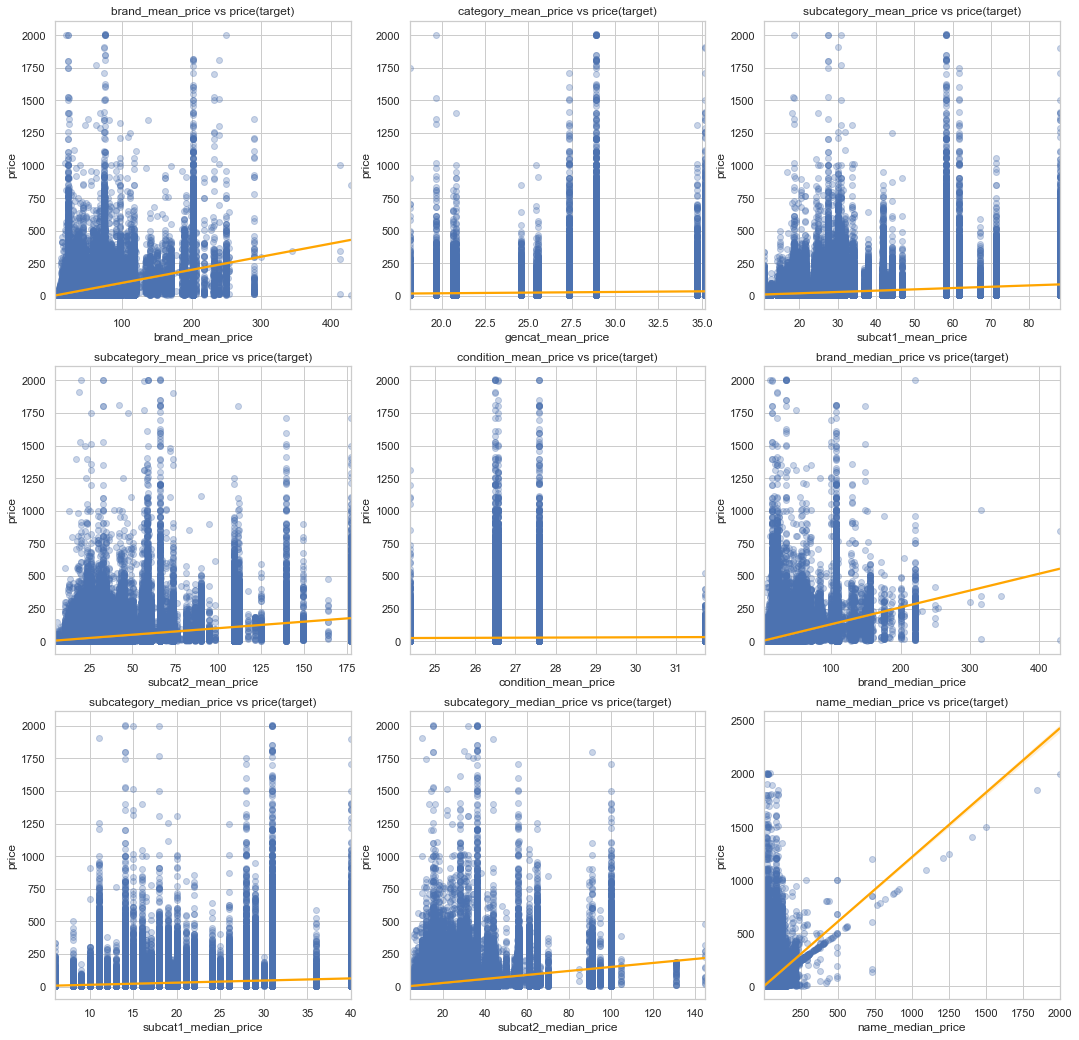

In [68]:
plt.figure(figsize=(18,18))

plt.subplot(3,3,1)
sns.regplot(x='brand_mean_price', y='price', data=df_train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('brand_mean_price vs price(target)')

plt.subplot(3,3,2)
sns.regplot(x='gencat_mean_price', y='price', data=df_train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('category_mean_price vs price(target)')

plt.subplot(3,3,3)
sns.regplot(x='subcat1_mean_price', y='price', data=df_train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('subcategory_mean_price vs price(target)')

plt.subplot(3,3,4)
sns.regplot(x='subcat2_mean_price', y='price', data=df_train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('subcategory_mean_price vs price(target)')

plt.subplot(3,3,5)
sns.regplot(x='condition_mean_price', y='price', data=df_train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('condition_mean_price vs price(target)')

plt.subplot(3,3,6)
sns.regplot(x='brand_median_price', y='price', data=df_train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('brand_median_price vs price(target)')

plt.subplot(3,3,7)
sns.regplot(x='subcat1_median_price', y='price', data=df_train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('subcategory_median_price vs price(target)')

plt.subplot(3,3,8)
sns.regplot(x='subcat2_median_price', y='price', data=df_train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('subcategory_median_price vs price(target)')

plt.subplot(3,3,9)
sns.regplot(x='name_median_price', y='price', data=df_train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('name_median_price vs price(target)')
            
plt.show()

#### Observation
-----------------

* Features names such as brand_mean_price, brand_median price, subcat2_mean_price, and subcat2_median_price show strong linear trends.


* Therefore they seem to be useful in determining the price of items.

In [70]:
#Dropping rows with blank name

n_rows = df_train.shape[0]
df_train = df_train[df_train['preprocessed_name'] != ''].reset_index(drop=True)

print('Dropped {} rows'.format(n_rows - df_train.shape[0]))

Dropped 19 rows


In [72]:
#Dropping rows with description

n_rows = df_train.shape[0]
df_train = df_train[df_train.preprocessed_description != ''].reset_index(drop=True)

print('Dropped {} rows'.format(n_rows - df_train.shape[0]))

print('Shape of train data: ', df_train.shape)

Dropped 567 rows
Shape of train data:  (1481075, 59)


In [73]:
print('Shape of test data: ', df_test.shape)

Shape of test data:  (693359, 58)


In [74]:
df_train.to_csv('train_final.csv',index=False)

df_test.to_csv('test_final.csv',index=False)